In [1]:
# train
# train
import torch
import torch.optim as optim
import models

from dataloader import get_dataloader


In [9]:
from easydict import EasyDict
args = EasyDict({
    'model_name': 'wgan',
    'dataset_name': 'cifar10',
    'data_root': '../data/',
    'resolution': 32,
    'classes_to_include': [0], #[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'batch_size': 128,
    'device': 'cuda',
    'nz': 100,
    'ngf': 64,
    'ndf': 64,
    'nc': 3,
    'lr':0.0002,
})


In [20]:
device = args.device

tot_itr = 10000
model_classes = [m for m in dir(models) 
                   if m.lower() == args.model_name.lower()]
assert model_classes, f'Model name {args.model_name} does not exist'
components = getattr(models, model_classes[0]).components

generator = components['generator'](args).train().to(device)
discriminator = components['discriminator'](args).train().to(device)
criterion = components['criterion'](args)
optimizer_g = components['optimizer'](args, params=generator.parameters())
optimizer_d = components['optimizer'](args, params=discriminator.parameters())
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

losses_d, losses_g = [], []

train_loader = get_dataloader(args, train=True)

train_iter = iter(train_loader)

for itr in range(tot_itr):
    try:
        imgs, _ = next(train_iter)
    except StopIteration:
        train_loader = get_dataloader(args, train=True)
        train_iter = iter(train_loader)
        imgs, _ = next(train_iter)
    imgs = imgs.to(device)

    # 1. Update Discriminator

    optimizer_d.zero_grad()
    real_pred = discriminator(imgs)

    noise = torch.randn(args.batch_size, args.nz, 1, 1).to(device)
    fake_imgs = generator(noise)
    fake_pred = discriminator(fake_imgs.detach())
    loss_d = criterion((fake_pred, real_pred), mode='discriminator_loss')
    losses_d.append(loss_d.item())

    loss_d.backward()
    optimizer_d.step()

    # 2. Update Generator
    optimizer_g.zero_grad()
    fake_pred = discriminator(fake_imgs)
    loss_g = criterion((fake_pred, real_pred), mode='generator_loss')
    losses_g.append(loss_g.item())

    loss_g.backward()
    optimizer_g.step()
    
    if (itr + 1) % int(tot_itr / 10) == 0:
        print('-' * 20)
        print(f'Iteration: {itr + 1}')
        print(f'Discriminator Loss: {loss_d.item()}')
        print(f'Generator Loss: {loss_g.item()}')


--------------------
Iteration: 1000
Discriminator Loss: -34.737693786621094
Generator Loss: -45.44599533081055
--------------------
Iteration: 2000
Discriminator Loss: -47.73945617675781
Generator Loss: -57.99388122558594
--------------------
Iteration: 3000
Discriminator Loss: -110.20509338378906
Generator Loss: -434.4126892089844
--------------------
Iteration: 4000
Discriminator Loss: -124.1885986328125
Generator Loss: -580.3916015625
--------------------
Iteration: 5000
Discriminator Loss: -194.4356689453125
Generator Loss: -390.82763671875
--------------------
Iteration: 6000
Discriminator Loss: -473.921875
Generator Loss: 8.216529846191406
--------------------
Iteration: 7000
Discriminator Loss: -870.190673828125
Generator Loss: -440.1915283203125
--------------------
Iteration: 8000
Discriminator Loss: -716.6361083984375
Generator Loss: -1079.1787109375
--------------------
Iteration: 9000
Discriminator Loss: -1296.5274658203125
Generator Loss: -5240.78515625
------------------

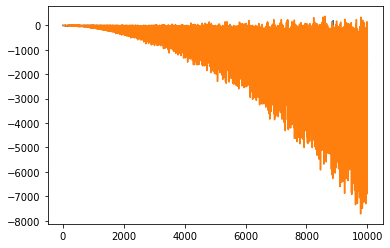

In [21]:
import matplotlib.pyplot as plt
plt.plot(losses_d)
plt.plot(losses_g)

In [24]:
def plot_images(imgs, ):
    import matplotlib.pyplot as plt
    import torchvision
    imgs = torchvision.utils.make_grid(imgs, normalize=True)
    plt.imshow(imgs.permute(1, 2, 0))

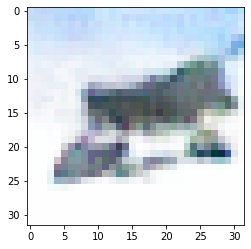

In [30]:
generator.eval().cpu()
with torch.no_grad():
    imgs = generator(torch.randn(1, args.nz, 1, 1))
plot_images(imgs)

In [132]:
import time
import os
from datetime import datetime


discriminator.cpu()
generator.train()
ckpt = {
    'generator': generator.state_dict(),
    'discriminator': discriminator.state_dict()
}
cur_time = datetime.now().strftime('%d%m%y.%H%M%S')
torch.save(ckpt, f'checkpoints/{args.model_name}.{cur_time}.pt')
print(list(os.walk('checkpoints')))

[('checkpoints', [], ['dcgan.270621.131451.pt', 'dcgan.270621.131500.pt', 'dcgan.270621.131506.pt', 'dcgan.pt'])]


In [2]:
import torchvision
from torch.utils.data import DataLoader

dataset = torchvision.datasets.MNIST('../data/')
dataloader = DataLoader(dataset)
next(iter(dataloader))

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>